<a href="https://colab.research.google.com/github/LudwigMeder/Time-Series-Prediction-of-the-NAO/blob/main/3_Model/ELM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides several models of the type Extreme Learning Machine (ELM) to predict the North Atlantic Oscillation index (NAO) on a monthly and a daily time scale. Several models mean different architectures and adding external information like providing the ENSO (El Nino - Southern Oscillaltion Index) as additional time series. Furthermore, several forecast schemes are tried and compared such as the "default" with predicting several time steps at once or the moving/rolling forecast.  

A first study which caught my interest about predicting the NAO with ELM was the following: The ELM Model with Residual Compensation Based on ARIMA for North Atlantic Oscillation Index Prediction https://dl.acm.org/doi/abs/10.1145/3459212.3459231 .

At the end of the notebook, a summary is provided.

# Import libraries and define functions

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
!pip install hpelm

In [3]:
from hpelm import ELM

In [4]:
from google.colab import drive

In [5]:
# Function to create input-output pairs for time series prediction
def create_input_output_pairs(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

def create_input_output_pairs_external(target_data, external_data, window_size, forecast_horizon):
  """
  target_data and external_data need to have the same shape
  """
  X, y = [], []
  for i in range(len(target_data) - window_size - forecast_horizon + 1):
      # Combine windows from both time series
      X.append(np.vstack((target_data[i:i + window_size], external_data[i:i + window_size])))
      # Only target series for the output
      y.append(target_data[i + window_size:i + window_size + forecast_horizon])
  return np.array(X), np.array(y)

# normalize the data
def normalize(data):
  """
  Returns normailzed data, MIN,MAX
  """
  MIN = min(data)
  MAX = max(data)
  normalized_data = (data - MIN)/(MAX-MIN)
  return normalized_data,MIN,MAX

def denormalize(normalized_data,MIN,MAX):
  """
  uses MIN and MAX of the original data to denormalize the normalized data
  """
  denormalized_data = normalized_data*(MAX-MIN) + MIN
  return denormalized_data

def phase_check(y_test,y_pred):
  """
  Args:
    y_test
    y_pred

  Returns: phase agreement of the two time series in percentage
  """

  #check for phases in y_test and y_pred:
  y_test_phases = np.zeros(len(y_test))
  y_pred_phases = np.zeros(len(y_pred))
  negative_test = np.where(y_test <-1)[0]# currently everything between -1 and 1 is set to neutral (might have to rethink tis interval)
  negative_pred = np.where(y_pred <-1)[0]
  positive_test = np.where(y_test >1)[0]
  positive_pred = np.where(y_pred >1)[0]
  y_test_phases[negative_test] = -1
  y_pred_phases[negative_pred] = -1
  y_test_phases[positive_test] = 1
  y_pred_phases[positive_pred] = 1
  counter = np.sum(y_test_phases==y_pred_phases)
  phase_percent = 100/len(y_test) * counter
  return phase_percent

# Monthly NAO Prediction

In [14]:
# load monthly dataset for period: 1825-01 - 2023-12
path_NAO_index_monthly = "https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-NAO/main/1_DatasetCharacteristics/NAO_INDEX_MONTHLY.csv"
NAO_index_monthly = pd.read_csv(path_NAO_index_monthly,delimiter=',')

# Convert the 'date' column to datetime
NAO_index_monthly['Date'] = pd.to_datetime(NAO_index_monthly['Date'])
# Set the 'date' column as the index
NAO_index_monthly.set_index('Date', inplace=True)

NAO_index_monthly

,NAO_index
Date,
1825-01-01,-0.226
1825-02-01,0.211
1825-03-01,0.327
1825-04-01,-0.276
1825-05-01,0.131
...,...
2023-08-01,-1.754
2023-09-01,-0.653
2023-10-01,-1.229


## Prediction with pure ELM

- Data editing  
- Building Model  
- Visualize Prediction

Data editing:  
- normalize data  
- set window size and forecast horizon (use window size [number of time steps] to predict the forecast horizon [number of time steps])  
- create input_output_pairs  
- split train and test dataset  
- reshape data suitable for ELM

In [17]:
# Normalize the data
NAO_normed,NAO_min,NAO_max = normalize(NAO_index_monthly['NAO_index'])

# Create input-output pairs
window_size = 24  # Use past 24 months for prediction
forecast_horizon = 1  # Predict next 1 month
X, y = create_input_output_pairs(NAO_normed, window_size, forecast_horizon)

# Split the data into training and testing sets based on time, with validation the training set is shorter and the predictions are getting worse
train_ratio, validation_ratio, test_ratio = 0.6, 0.0, 0.4
#split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_val, X_test = X[:int(len(X)*train_ratio)], X[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], X[int(len(X)*train_ratio + len(X)*validation_ratio):]
y_train, y_val, y_test = y[:int(len(X)*train_ratio)], y[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], y[int(len(X)*train_ratio + len(X)*validation_ratio):]

# Reshape data for ELM
X_train_flat = X_train.reshape(X_train.shape[0], -1)
# X_val_flat = X_val.reshape(X_val.shape[0], -1) # for validation
X_test_flat = X_test.reshape(X_test.shape[0], -1)

y_train_flat = y_train.reshape(y_train.shape[0], -1)
# y_val_flat = y_val.reshape(y_val.shape[0], -1) # for validation
y_test_flat = y_test.reshape(y_test.shape[0], -1)

Building Model:  
- ELM architecture  
- training  
- testing  
- denormalize predictions  
- calculate MSE and phase ratio

In [18]:
# Initialize and train the ELM model
elm = ELM(X_train_flat.shape[1], y_train_flat.shape[1],batch=20)
elm.add_neurons(10, 'tanh') #'sigm' , 'tanh'
elm.train(X_train_flat, y_train_flat) # with validation add: , 'V', Xv=X_val_flat, Tv=y_val_flat,learning_rate=0.001) # , 'r' - for regression, , 'OP' - using the best neurons

# Make predictions
y_pred_flat = elm.predict(X_test_flat)
y_pred = y_pred_flat.reshape(y_pred_flat.shape[0], forecast_horizon, -1)


# Inverse transform the predictions to get actual values
y_test_actual = denormalize(y_test_flat,NAO_min,NAO_max)
y_pred_actual = denormalize(y_pred_flat,NAO_min,NAO_max)

# Calculate the mean squared error
mse = mean_squared_error(y_test_actual, y_pred_actual)
phase_ratio = phase_check(y_test_actual,y_pred_actual)
print(f'Mean Squared Error: {mse}')
print("Ratio of correct predicted phases = ", phase_ratio)

Mean Squared Error: 3.011598118807856
Ratio of correct predicted phases =  41.9661733615222


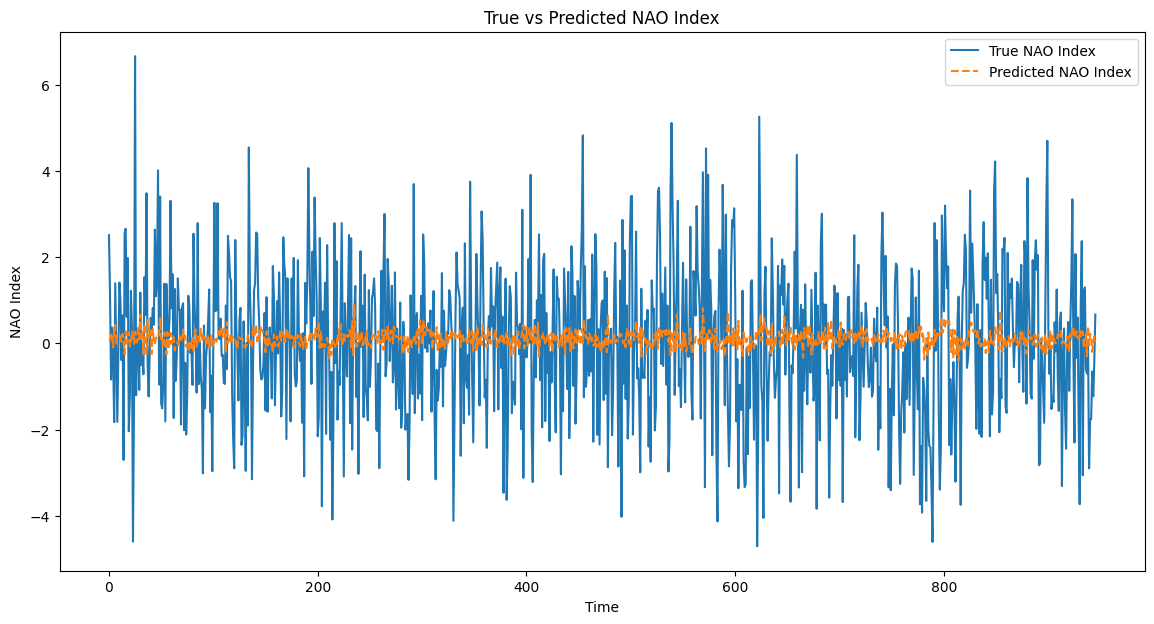

In [19]:
# Plotting the true and predicted NAO index values
plt.figure(figsize=(14, 7))

# Flatten the arrays for plotting
true_values = y_test_actual.flatten()
predicted_values = y_pred_actual.flatten()

# Create time points for plotting
time_points = np.arange(len(true_values))

plt.plot(time_points, true_values, label='True NAO Index')
plt.plot(time_points, predicted_values, label='Predicted NAO Index', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('True vs Predicted NAO Index')
plt.legend()
plt.show()

Appearingly the model didn't learn somethin at all.  
But nevertheless, maybe the additional dataset of Nino 3.4 will improve it.

## Prediction with an external time series: EL Nino index 3.4

- Load and Visualize and Edit Data  
- Build Model  
- Visualize Prediction

Data editing:  
- loading data  
- visualize both time series  
- slice it to the same time period
- normalizing  
- create input_output pairs  
- split for testing and training

In [22]:
# load monthly NAO dataset for period: 1825-01 - 2023-12
path_NAO_index_monthly = "https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-NAO/main/1_DatasetCharacteristics/NAO_INDEX_MONTHLY.csv"
NAO_index_monthly = pd.read_csv(path_NAO_index_monthly,delimiter=',')

# Convert the 'Date' column to datetime
NAO_index_monthly['Date'] = pd.to_datetime(NAO_index_monthly['Date'])
# Set the 'date' column as the index
NAO_index_monthly.set_index('Date', inplace=True)

########## Dataset Nino index 3.4 ##################
# load monthly Nino dataset for period: 1870-01 - 2024-12 (at the end nan)
path_Nino_index_monhtly = "https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-NAO/main/1_DatasetCharacteristics/Nino_index.csv"
Nino3_4_monthly = pd.read_csv(path_Nino_index_monhtly,delimiter=',')

# Convert the 'Date' column to datetime
Nino3_4_monthly['Date'] = pd.to_datetime(Nino3_4_monthly['Date'])
# Set the 'date' column as the index
Nino3_4_monthly.set_index('Date', inplace=True)
Nino3_4_monthly


print(NAO_index_monthly.head(),Nino3_4_monthly.head())

            NAO_index
Date                 
1825-01-01     -0.226
1825-02-01      0.211
1825-03-01      0.327
1825-04-01     -0.276
1825-05-01      0.131             Nino_index
Date                  
1870-01-01       -1.00
1870-02-01       -1.20
1870-03-01       -0.83
1870-04-01       -0.81
1870-05-01       -1.27


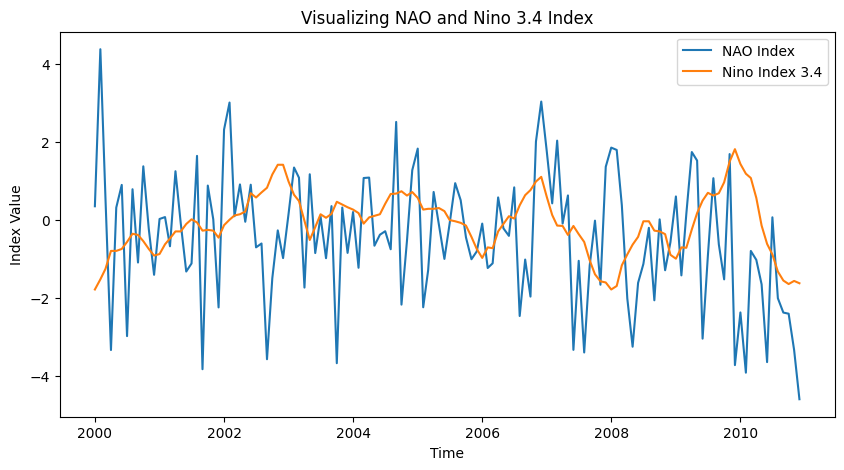

In [36]:
index_start = '2000-01-01'
index_end = '2010-12-31'
time = NAO_index_monthly.loc[index_start:index_end].index

plt.figure(figsize=(10,5))
plt.plot(time,NAO_index_monthly.loc[index_start:index_end].values,label='NAO Index')
plt.plot(time,Nino3_4_monthly.loc[index_start:index_end].values,label='Nino Index 3.4')

plt.title("Visualizing NAO and Nino 3.4 Index")
plt.ylabel('Index Value')
plt.xlabel('Time')
plt.legend()
plt.show()


In [37]:
# slice the dataframes to the same time period
## NAO index: 1825-01-01 to 2023-12-01
## Nino index: 1870-01-01 to 2024-03-01
## common time span: 1870-01-01 to 2023-12-01
date_start = '1870-01-01'
date_end = '2023-12-01'
NAO_index_sliced = NAO_index_monthly.loc[date_start:date_end]
Nino3_4_sliced = Nino3_4_monthly.loc[date_start:date_end]

NAO_index_sliced, Nino3_4_sliced

(            NAO_index
 Date                 
 1870-01-01      0.319
 1870-02-01     -1.978
 1870-03-01     -2.072
 1870-04-01      2.918
 1870-05-01      1.546
 ...               ...
 2023-08-01     -1.754
 2023-09-01     -0.653
 2023-10-01     -1.229
 2023-11-01     -0.427
 2023-12-01      0.671
 
 [1848 rows x 1 columns],
             Nino_index
 Date                  
 1870-01-01       -1.00
 1870-02-01       -1.20
 1870-03-01       -0.83
 1870-04-01       -0.81
 1870-05-01       -1.27
 ...                ...
 2023-08-01        1.56
 2023-09-01        1.65
 2023-10-01        1.59
 2023-11-01        2.01
 2023-12-01        1.81
 
 [1848 rows x 1 columns])

In [39]:
# Normalize the data
NAO_normed,NAO_min,NAO_max = normalize(NAO_index_sliced['NAO_index'])
Nino_norm,Nino_min,Nino_max = normalize(Nino3_4_sliced["Nino_index"])

# Create input-output pairs
window_size = 36  # Use past 36 months for prediction
forecast_horizon = 1  # Predict next 1 months
X, y = create_input_output_pairs_external(NAO_normed,Nino_norm, window_size, forecast_horizon)

# Split the data into training and testing sets based on time
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape data for ELM
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

Build model

In [41]:
# Initialize and train the ELM model
elm = ELM(X_train_flat.shape[1], y_train_flat.shape[1],batch = 100) # batch could be adjusted, default = 1000
elm.add_neurons(73, 'tanh') #'sigm' , 'tanh'
elm.train(X_train_flat, y_train_flat, 'MSE')


# Make predictions
y_pred_flat = elm.predict(X_test_flat)
y_pred = y_pred_flat.reshape(y_pred_flat.shape[0], forecast_horizon, -1)


# Inverse transform the predictions to get actual values
y_test_actual = denormalize(y_test_flat,NAO_min,NAO_max)
y_pred_actual = denormalize(y_pred_flat,NAO_min,NAO_max)

# Flatten the arrays for plotting
true_values = y_test_actual.flatten()
predicted_values = y_pred_actual.flatten()

# Calculate the mean squared error
mse = mean_squared_error(y_test_actual, y_pred_actual)
phase_ratio = phase_check(y_test_actual,y_pred_actual)
print(f'Mean Squared Error: {mse}')
print("Ratio of correct predicted phases = ", phase_ratio)


Mean Squared Error: 3.4724701779953357
Ratio of correct predicted phases =  38.01652892561984


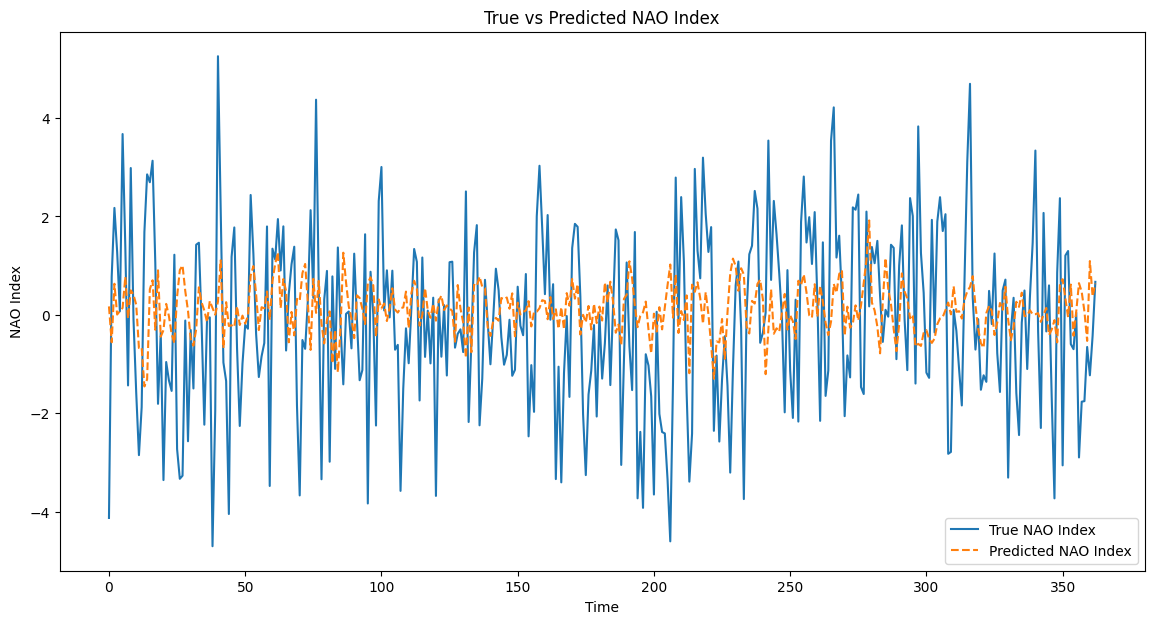

In [42]:
# Plotting the true and predicted NAO index values
plt.figure(figsize=(14, 7))
# Create time points for plotting
time_points = np.arange(len(true_values))

plt.plot(time_points, true_values, label='True NAO Index')
plt.plot(time_points, predicted_values, label='Predicted NAO Index', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('True vs Predicted NAO Index')
plt.legend()
plt.show()

Because input layer is just a single layer it is a longer vector together with the nino index. There is no improvement regarding the model without the nino index.

# Daily NAO prediction with ELM

- Load and Edit Data  
- Build Model  
- Visualize Prediction

In [6]:
# load daily dataset for period: 1950-01-01 - 2024-05-12
path_NAO_index_daily = "https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-NAO/main/1_DatasetCharacteristics/NAO_INDEX_DAILY.csv"

NAO_index_daily = pd.read_csv(path_NAO_index_daily,delimiter=',')

# Convert the 'date' column to datetime
NAO_index_daily['date'] = pd.to_datetime(NAO_index_daily['date'])
# Set the 'date' column as the index
NAO_index_daily.set_index('date', inplace=True)

NAO_index_daily

,nao_index_daily
date,
1950-01-01,0.365000
1950-01-02,0.096000
1950-01-03,-0.416000
1950-01-04,-0.616000
1950-01-05,-0.261000
...,...
2024-05-08,0.246422
2024-05-09,0.475453
2024-05-10,0.656409


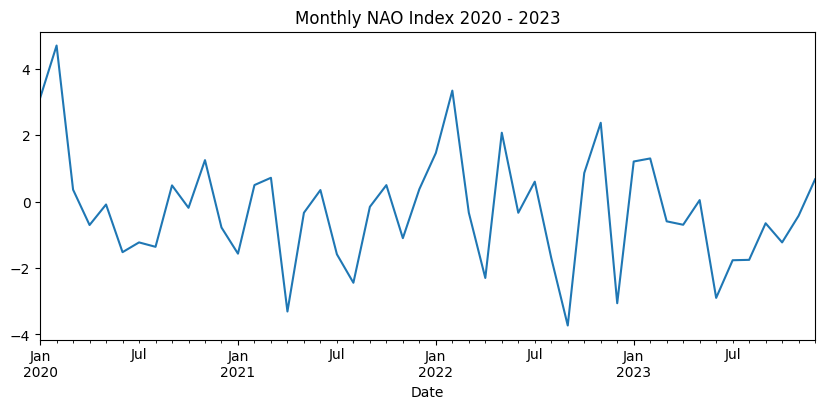

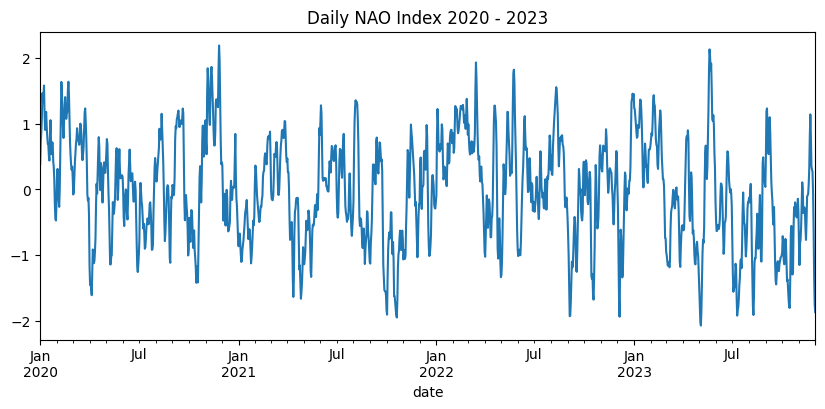

In [44]:
# plot monthly dataset:
FIGSIZE=(10,4)

plt.figure(figsize=FIGSIZE)
NAO_index_monthly['2020-01-01':'2023-12-01']['NAO_index'].plot()
plt.title('Monthly NAO Index 2020 - 2023')
plt.show()

# plot daily dataset:
plt.figure(figsize=FIGSIZE)
NAO_index_daily['2020-01-01':'2023-12-01']['nao_index_daily'].plot()
plt.title('Daily NAO Index 2020 - 2023')
plt.show()

Edit data

In [7]:
## Normalize the data
NAO_normed,NAO_min,NAO_max = normalize(NAO_index_daily['nao_index_daily'])

# Create input-output pairs
window_size = 20
forecast_horizon = 1
X, y = create_input_output_pairs(NAO_normed, window_size, forecast_horizon)

train_ratio, validation_ratio, test_ratio = 0.8, 0.0, 0.2

X_train, X_val, X_test = X[:int(len(X)*train_ratio)], X[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], X[int(len(X)*train_ratio + len(X)*validation_ratio):]
y_train, y_val, y_test = y[:int(len(X)*train_ratio)], y[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], y[int(len(X)*train_ratio + len(X)*validation_ratio):]


# Reshape data for ELM
X_train_flat = X_train.reshape(X_train.shape[0], -1)
#X_val_flat = X_val.reshape(X_val.shape[0], -1) # used for validation
X_test_flat = X_test.reshape(X_test.shape[0], -1)

y_train_flat = y_train.reshape(y_train.shape[0], -1)
#y_val_flat = y_val.reshape(y_val.shape[0], -1) # used for validation
y_test_flat = y_test.reshape(y_test.shape[0], -1)

build model

In [8]:
# Initialize and train the ELM model
elm = ELM(X_train_flat.shape[1], y_train_flat.shape[1],batch=200)
elm.add_neurons(128, 'sigm') # , 'tanh'
elm.train(X_train_flat, y_train_flat, 'MSE')#, 'V', Xv=X_val_flat, Tv=y_val_flat)

# Make predictions
y_pred_flat = elm.predict(X_test_flat)

# Inverse transform the predictions to get actual values
y_test_actual = denormalize(y_test_flat,NAO_min,NAO_max)
y_pred_actual = denormalize(y_pred_flat,NAO_min,NAO_max)


# Flatten the arrays for plotting
true_values = y_test_actual.flatten()
predicted_values = y_pred_actual.flatten()

# Calculate the mean squared error
mse = mean_squared_error(y_test_actual.flatten(), y_pred_actual.flatten())
mae = mean_absolute_error(y_test_actual.flatten(), y_pred_actual.flatten())
phase_ratio = phase_check(y_test_actual.flatten(),y_pred_actual.flatten())
print(f'Mean Squared Error: {mse}')
print(f'Man Absolut Error: {mae}')
print("Ratio of correct predicted phases = ", phase_ratio)

Mean Squared Error: 0.04488007741702606
Man Absolut Error: 0.1624166283991358
Ratio of correct predicted phases =  91.43488671946952


Visualize predictions

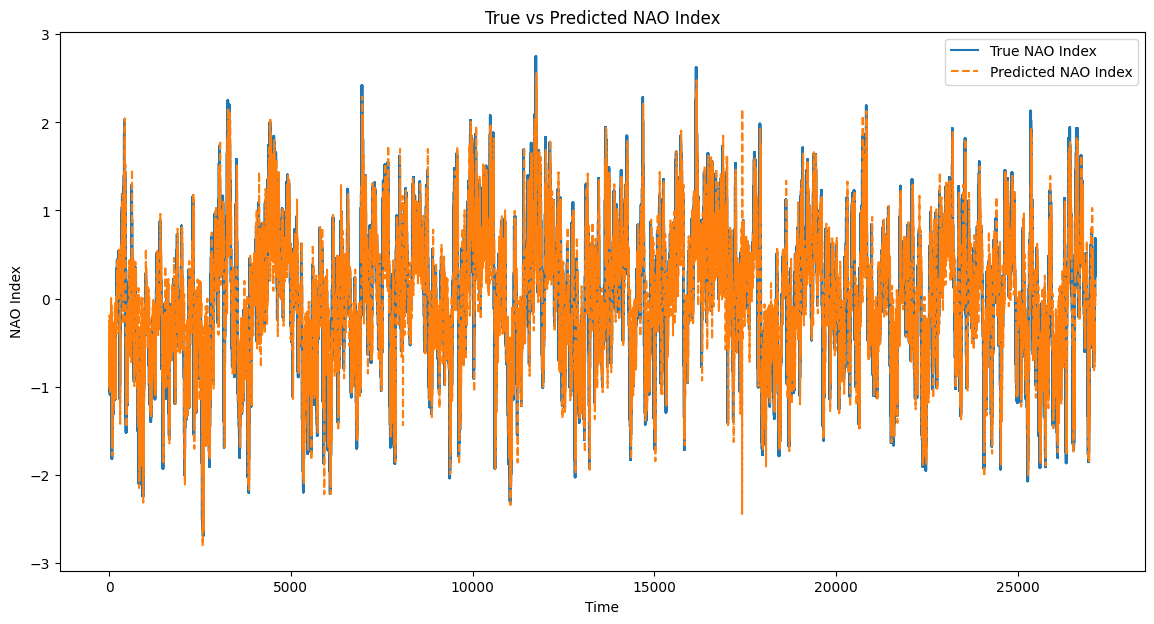

In [57]:
# Plotting the true and predicted NAO index values
plt.figure(figsize=(14, 7))
# Create time points for plotting
time_points = np.arange(len(true_values))

plt.plot(time_points, true_values, label='True NAO Index')
plt.plot(time_points, predicted_values, label='Predicted NAO Index', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('True vs Predicted NAO Index')
plt.legend()
plt.show()

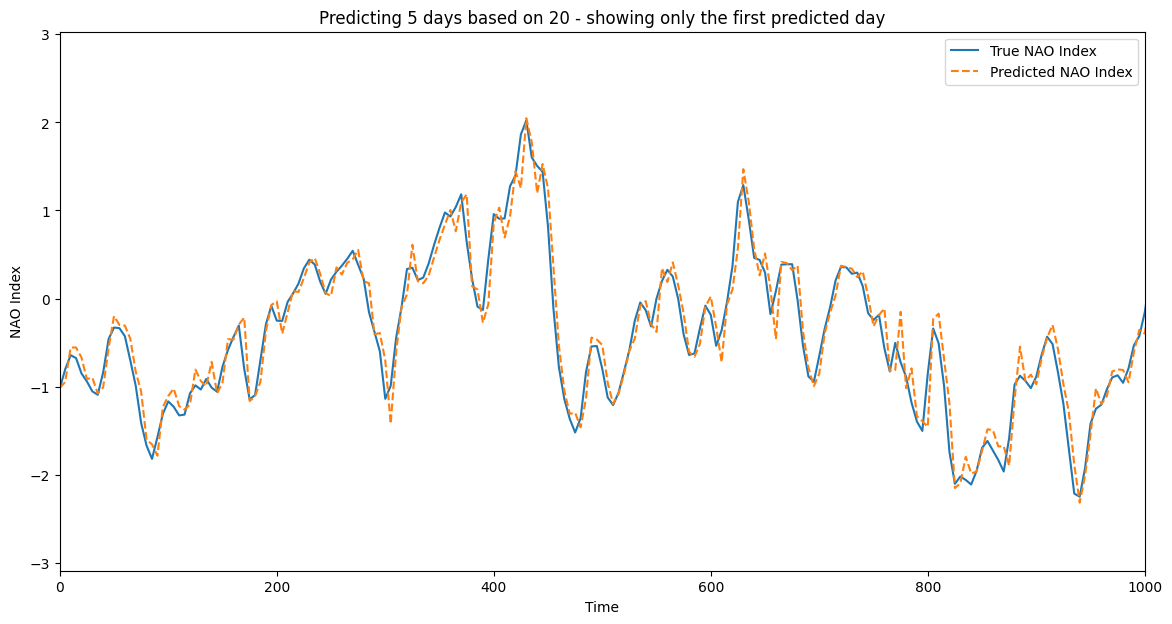

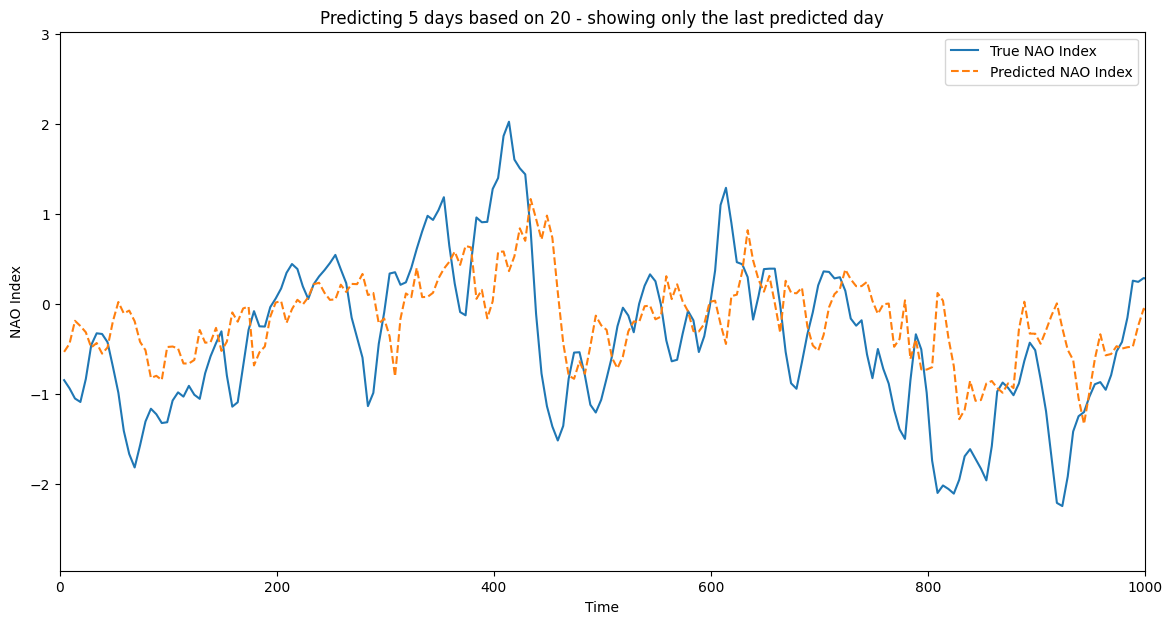

In [58]:
plt.figure(figsize=(14, 7))

# Flatten the arrays for plotting
true_values = y_test_actual.flatten()
predicted_values = y_pred_actual.flatten()

# Create time points for plotting
time_points = np.arange(len(true_values))

plt.plot(time_points[0::5], true_values[0::5], label='True NAO Index')
plt.plot(time_points[0::5], predicted_values[0::5], label='Predicted NAO Index', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('Predicting 5 days based on 20 - showing only the first predicted day')
plt.xlim(0,1000)
plt.legend()
plt.show()


plt.figure(figsize=(14, 7))

# Flatten the arrays for plotting
true_values = y_test_actual.flatten()
predicted_values = y_pred_actual.flatten()

# Create time points for plotting
time_points = np.arange(len(true_values))

plt.plot(time_points[4::5], true_values[4::5], label='True NAO Index')
plt.plot(time_points[4::5], predicted_values[4::5], label='Predicted NAO Index', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('Predicting 5 days based on 20 - showing only the last predicted day')
plt.xlim(0,1000)
plt.legend()
plt.show()

- Window size: [14,1], 64 neurons, sigm -> MSE: 0.045, ratio: 91.7%  
- Window size: [14,5], 128 neurons, sigm -> MSE: 0.275, ratio: 80.7%  
- Window size: [62,14], 128 neurons, sigm -> MSE: 0.508, ratio: 76.4%  
- Window size: [123,31] 128 neurons, sigm -> MSE: 0.628, ratio: 75.1%

The longer the forecast range the higher the uncertainties! Thus, a rolling forecast could imporve the forecast.

With rolled forecast:
- window size [14,1], forecast_range = 5: MSE: 0.276, ratio: 80.6%
- window size [31,1], forecast_range = 14: MSE: 0.517, ratio: 76.4%



## Predicting Daily Data with a rolling forecast

In [9]:
def rolling_forecast(historical, forecast_range, model, model_prediction=1):
  hist = historical
  predictions = []
  for _ in range(forecast_range):

    pred = model.predict(hist)
    hist = np.append(hist[:,model_prediction:], pred).reshape(1,-1)

    predictions.append(np.squeeze(pred))
  predictions = np.array(predictions)

  return predictions

def predict_rolling_test(X_test, y_test, forecast_range, model):
  number_pred = len(X_test[:,1]) - forecast_range - len(X_test[0])

  Y = np.squeeze(y_test)

  predictions = []
  true_predictions = []
  for i in range(number_pred):
    predictions.append(rolling_forecast(X_test[i][np.newaxis,:],forecast_range,model))
    true_predictions.append(Y[i:i+forecast_range])

  return predictions, true_predictions

In [10]:
# predict - !!!!!!!only works if elm model is trained with predicting one value!!!!!

forecast_range = 14
y_pred, y_test = predict_rolling_test(X_test_flat, y_test_flat,forecast_range, elm)

# denormalize
y_test_flat = np.array(y_test)
y_pred_flat = np.array(y_pred)

y_test_actual = denormalize(y_test_flat,NAO_min,NAO_max)
y_pred_actual = denormalize(y_pred_flat,NAO_min,NAO_max)


# measures such as MSE and phase
# Calculate the mean squared error
mse = mean_squared_error(y_test_actual.flatten(), y_pred_actual.flatten())
phase_ratio = phase_check(y_test_actual.flatten(),y_pred_actual.flatten())
print(f'Mean Squared Error: {mse}')
print("Ratio of correct predicted phases = ", phase_ratio)

Mean Squared Error: 0.5173084932137945
Ratio of correct predicted phases =  76.39878194095061


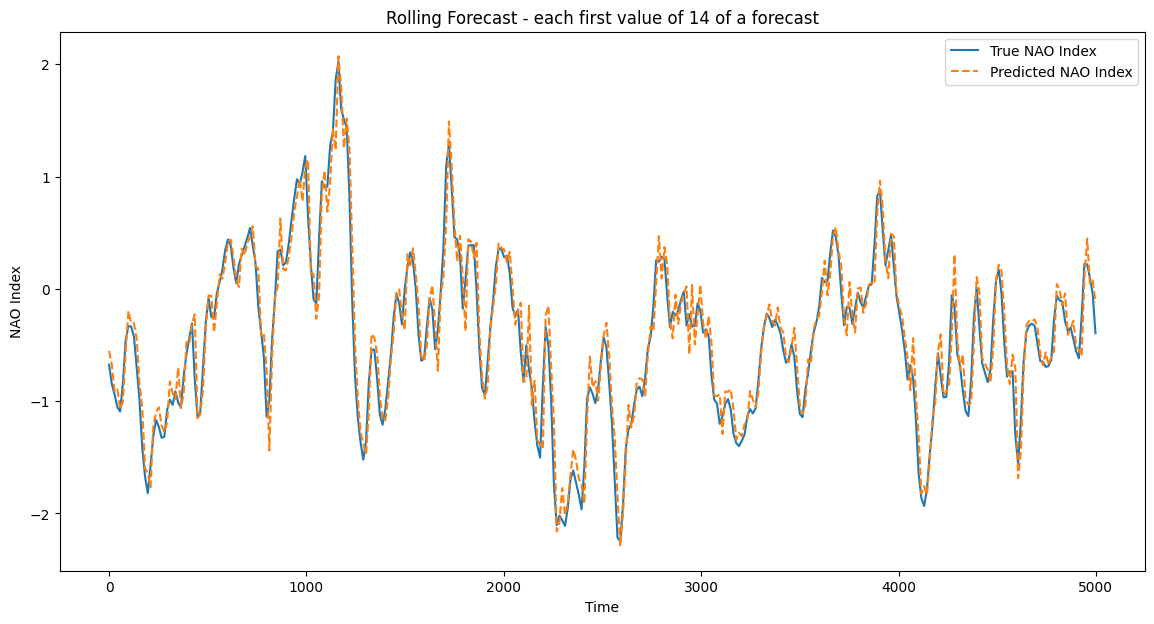

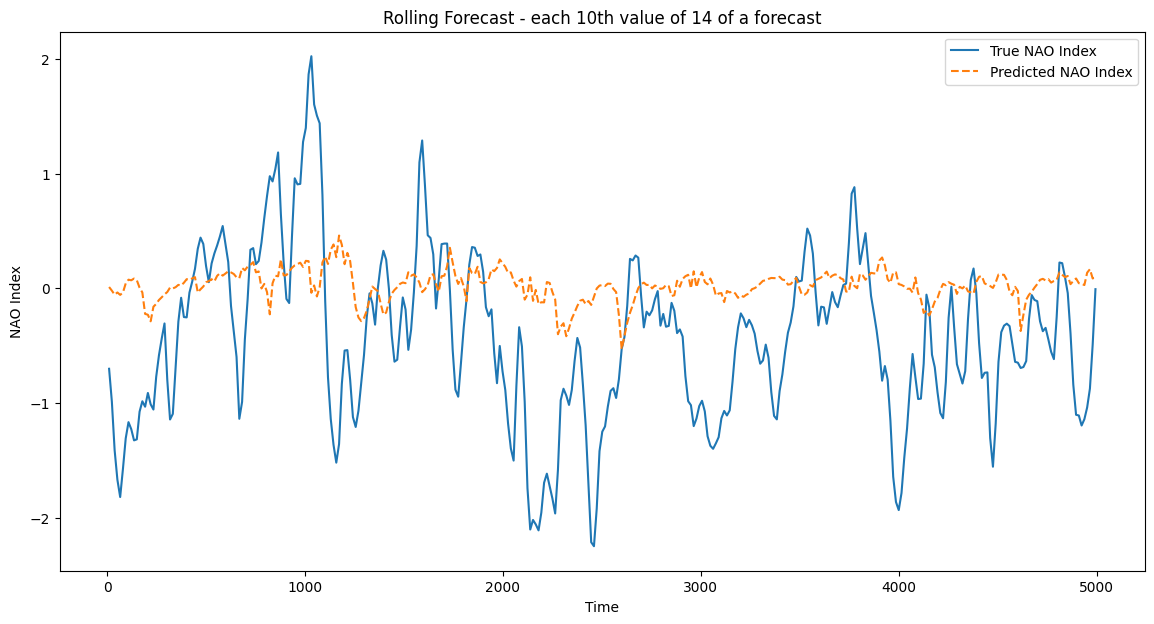

In [19]:
# Plotting the true and predicted NAO index values
plt.figure(figsize=(14, 7))

# Flatten the arrays for plotting
true_values = y_test_actual.flatten()
predicted_values = y_pred_actual.flatten()

# Create time points for plotting
time_points = np.arange(len(true_values))
I = 0
plt.plot(time_points[0:5000][I::14], true_values[0:5000][I::14], label='True NAO Index')
plt.plot(time_points[0:5000][I::14], predicted_values[0:5000][I::14], label='Predicted NAO Index', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('Rolling Forecast - each first value of 14 of a forecast')
plt.legend()
plt.show()

# Plotting the true and predicted NAO index values
plt.figure(figsize=(14, 7))

# Flatten the arrays for plotting
true_values = y_test_actual.flatten()
predicted_values = y_pred_actual.flatten()

# Create time points for plotting
time_points = np.arange(len(true_values))
I = 10
plt.plot(time_points[0:5000][I::14], true_values[0:5000][I::14], label='True NAO Index')
plt.plot(time_points[0:5000][I::14], predicted_values[0:5000][I::14], label='Predicted NAO Index', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('Rolling Forecast - each 10th value of 14 of a forecast')
plt.legend()
plt.show()

# Summary

__Monthly Dataset__  
The ELM didn't really showed a good ability to predict the monthly NAO. With the external dataset ENSO, the performance got worse. A reason could be the lagged connection. Here, both time series were parallel in time but the input could also be shifted in time which would account for the lagged connection.

__Daily Dataset__  
The ELM model has a very good performance for predicting one or very few days. But the longer the forecast range is, the higher the uncertainties get. Thus, a moving/rolling forecast was the approach to minimize the prediction error. But at the end, the uncertainties are as high as for the "default forecast".